# 卷积神经网络(LeNet)

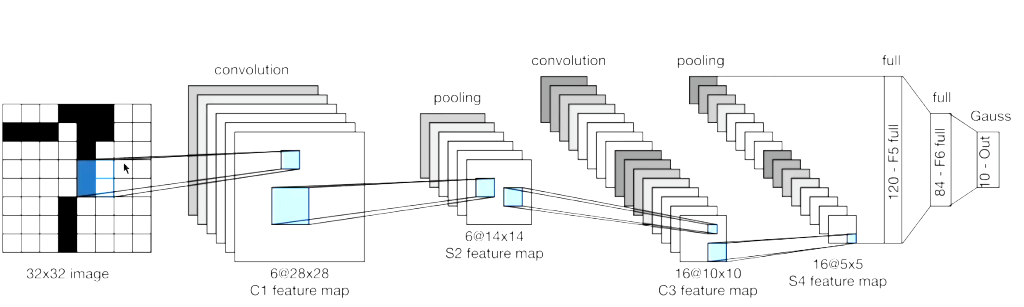

总结
- LeNet是早期成功的神经网络
- 先使用卷积层来学习图片空间信息
- 然后使用全连接层来转换到类别空间

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
#LeNet结构
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding= 2),
                    nn.AvgPool2d(kernel_size= 2, stride= 2),
                    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size= 2, stride= 2),
                    nn.Flatten(),
                    nn.Linear(16*5*5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10))

In [3]:
X = torch.rand(size= (1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
#在Fashion-MNIST数据集上进行LeNet模型训练
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size= batch_size) 

In [7]:
#定义正确率函数
def evaluate_accuracy_gpu(net, data_iter, device= None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval() #设置为评估模式
        if not device:
            #如果没提供设备信息，则查看模型层中设备信息
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric [1]

In [8]:
#定义训练函数
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""
    def init_weight(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weight)
    print('training on', device)
    net.to(device)
    #定义优化器(随机梯度下降法)
    optimizer = torch.optim.SGD(net.parameters(), lr= lr)
    #定义损失函数(交叉熵损失)
    loss = nn.CrossEntropyLoss()
    #绘制动态训练曲线
    animator = d2l.Animator(xlabel= 'epoch', xlim= [1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        #训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            #进行预测
            y_hat = net(X)
            l = loss(net(X), y)
            #反向传播
            l.backward()
            #优化器迭代
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            #训练误差和训练正确率
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches == 5:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l: .3f}, train acc {train_acc: .3f}, '
          f'test_acc {test_acc: .3f}')
    print(f'loss {metric[2]* num_epochs / timer.sum(): .1f}, examples/sec'
          f'on {str(device)}')

training on cuda:0


TypeError: 'int' object is not iterable

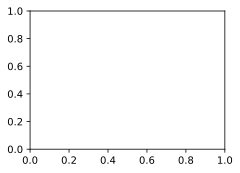

In [9]:
lr, num_epochs = 0.9, 20
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())